In [1]:
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from PIL import Image
from tqdm import tqdm
import random
import torchmetrics
import torch
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
import load_dataset
import predictions

# **EfficientNet Inference and Evaluation**

## Loading Data and Model

In [2]:
with open('labels.json') as f:
 labels = list(json.load(f).values())


In [3]:
with open('categories.json') as f:
    categories = json.load(f)

In [4]:
print(len(labels))  # number of validation images
print(len(list(set(labels))))    # number of classes
cnt = Counter(labels)
print(list(set(cnt.values()))) # number of images per class

50000
1000
[50]


The dataset contains 50000 images split equally into 1000 images (50 images per class)

The following cell displays 16 randomly sampled images from a chosen class

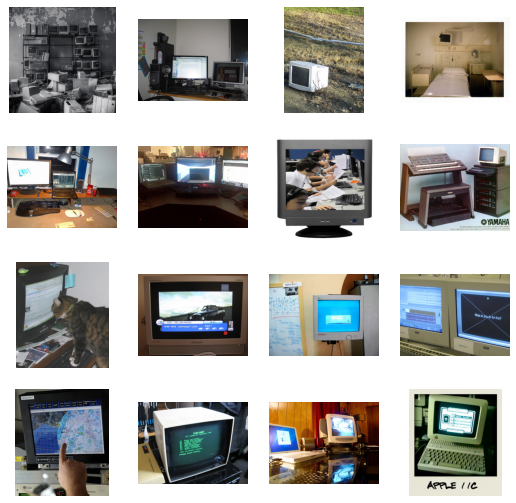

In [33]:
def plot_images(cls):
    ''' Plot 16 randomly selected images form the class cls
    '''
    idx = [i for i in range(len(labels)) if labels[i] == cls]
    fig, ax = plt.subplots(4, 4, figsize=(9, 9))
    images = np.array(os.listdir('./dataset'))[idx]
    images = random.sample(list(images), 16)
    for i in range(4):
        for j in range(4):
            ax[i, j].imshow(np.array(Image.open('./dataset/'+images[i*4+j])))
            ax[i, j].axis('off')
    plt.show()

plot_images(782)

We load the EfficientNet model from https://pypi.org/project/efficientnet-pytorch/.
Since it is a Pytorch model, the input images require a specific format that will be detailed later.

In [6]:
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [25]:
data_loader = load_dataset.create_dataloader(batch_size=16,
                                shuffle=False,
                                pin_memory=False,
                                num_workers=4)

classes = load_dataset.load_json('categories.json')

Generate logits (vectors of probabilities) and save the results as an .npy file

In [64]:
labels, logits = predictions.predictions(data_loader, model)

100%|██████████| 3125/3125 [1:12:56<00:00,  1.40s/it]


In [66]:
np.save('logits.npy', logits.detach().numpy())

The following metrics will be used, both globally (for across all samples and all classes), and locally (calculated the metrics for each class separately and returns the metrics for every class)

In [5]:
# global metrics

metrics = [
    torchmetrics.Accuracy(num_classes=1000),
    torchmetrics.Accuracy(num_classes=1000, top_k=5),
    torchmetrics.F1Score(num_classes=1000),
    torchmetrics.Precision(num_classes=1000),
    torchmetrics.Recall(num_classes=1000),
    torchmetrics.Specificity(num_classes=1000)
    ]

metrics_names = ["Accuracy", "Top 5 Accuracy", "F1 score", "Precision", "Recall", "Specificity"]

# local (class) metrics

class_metrics = [
    torchmetrics.Accuracy(num_classes=1000, arverage="none"),
    torchmetrics.Accuracy(num_classes=1000, average = "none", top_k=5),
    torchmetrics.F1Score(num_classes=1000, average="none"),
    torchmetrics.Precision(num_classes=1000, average="none"),
    torchmetrics.Recall(num_classes=1000, average="none"),
    torchmetrics.Specificity(num_classes=1000, average="none")
    ]
    
class_metrics_names = ["Accuracy", "Top 5 Accuracy", "F1 score", "Precision", "Recall", "Specificity"]

In [20]:
labels = torch.Tensor(labels).long()
for metric, name in zip(metrics, metrics_names):
    if name != 'Specificity':
        print(name + ": " + "{:.1f}".format(metric(logits, labels)*100) + '%')
    else:
        print(name + ": " + "{:.2f}".format(metric(logits, labels)*100) + '%')

Accuracy: 74.3%
Top 5 Accuracy: 91.9%
F1 score: 74.3%
Precision: 74.3%
Recall: 74.3%
Specificity: 99.97%


On the entire validation set, we get a 74.3% accuracy and a 91.9% top-5 accuracy. Those results are comparable to what is obtained in the EfficientNet paper. The authors got 77.1% and 93.3% for the accuracy and the top-5 accuracy respectively on the ImageNet validation dataset.

In [6]:
def plot_histogram(idx):
    ''' Plot the histogram and the distribution of the number of the accuracies / top-5 accuracies for each class of idx
    '''
    #predictions, predictions_top = np.load('predictions.npy'), np.load('predictions_top5.npy')
    logits = np.load('logits.npy')
    accuracy = []
    top5_accuracy = []
    #for i in tqdm(range(1000)):
        #idx = [j for j in range(len(labels)) if labels[j] == i]
    for i in idx:
        indexes = [j for j in range(len(labels)) if labels[j] == i]
        labels_reduced = np.array(labels)[indexes]
        logits_reduced = logits[indexes]
        # predictions_reduced = np.array(predictions)[indexes]
        # predictions_labels_top_reduced = np.array(predictions_top)[indexes]
        # accuracy.append(accuracy_score(labels_reduced, predictions_reduced))
        # top5_accuracy.append(top_accuracy(labels_reduced, predictions_labels_top_reduced))
        accuracy.append(metrics[0](torch.Tensor(logits_reduced), torch.Tensor(labels_reduced).long()).item())
        top5_accuracy.append(metrics[1](torch.Tensor(logits_reduced), torch.Tensor(labels_reduced).long()).item())
    ax = sns.histplot(data=accuracy, bins=20, kde=True)
    mean = np.mean(accuracy)
    plt.plot([mean, mean], [0, 3], 'r--')
    ax.set(xlabel='Accuracy', ylabel='Count')
    plt.show()

    ax = sns.histplot(data=top5_accuracy, bins=20, kde=True)
    mean = np.mean(top5_accuracy)
    plt.plot([mean, mean], [0, 3], 'r--')
    ax.set(xlabel='Top 5 Accuracy', ylabel='Count')
    plt.show()


The previous function can be used to vizualise the performances on a subgroup of labels, here are the distributions on a randomly chosen subset of 60 labels. The red dotted vertical line on the plots is the mean of the distribution.

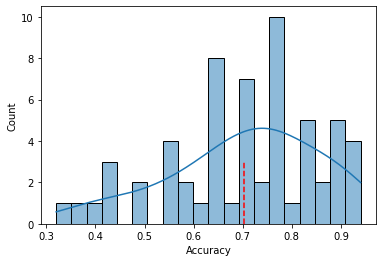

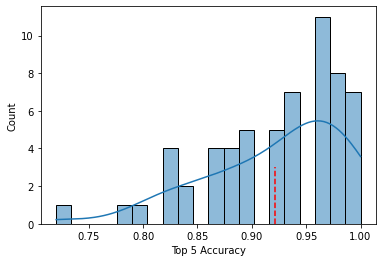

In [7]:
selected_labels = random.sample([i for i in range(1000)], 60)
plot_histogram(selected_labels)

We can also observe the distributions of similar classes only. Here I considered labels from 52 to 68. It corresponds to different types of snakes.

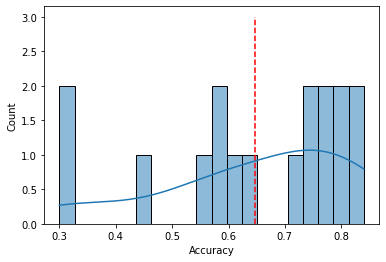

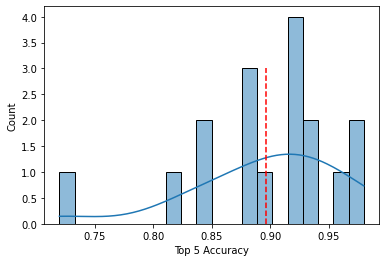

In [8]:
selected_labels = [i for i in range(52,69)]
plot_histogram(selected_labels)

Let's know generate a classification report: it sums up different metrics for each of the 1000 classes.

In [26]:
values = []
for metric in class_metrics:
    values.append(metric(logits, labels))

df = {
    "Class": classes.loc[:, 0].values,
    **dict(zip(class_metrics_names, values))
    }
df = pd.DataFrame(df)

df.to_csv("classification_report.csv")

The precision is $TP/(TP+FP)$, the recall is $TPR=TP/(TP+FN)$ and the F1-score is the harmonic mean of precision and recall. Specificity is defined as $TN/(TN+FP)$.

Note that specificity is very high for all classes (see classification report). It is not a relevant metric for our problem because for each class, there are much more TN (the model correctly predicts when an image is not from the considered class) than FP (predicts an other class for an image from the considered class) since a class only represents 50 images over 1000.

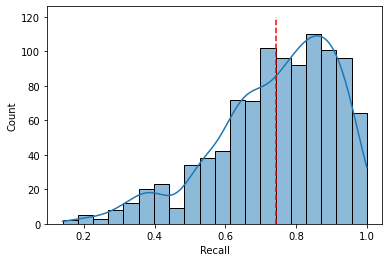

In [27]:
recall = np.array(pd.read_csv('classification_report.csv')['Recall'])
ax = sns.histplot(data=recall, bins=20, kde=True)
mean = np.mean(recall)
plt.plot([mean, mean], [0, 120], 'r--')
ax.set(xlabel='Recall', ylabel='Count')
plt.show()


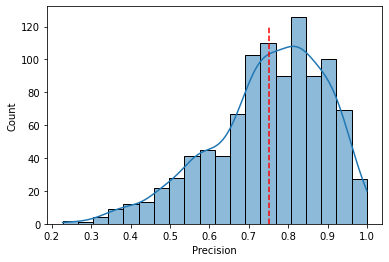

In [28]:
precisions = np.array(pd.read_csv('classification_report.csv')['Precision'])
ax = sns.histplot(data=precisions, bins=20, kde=True)
mean = np.mean(precisions)
plt.plot([mean, mean], [0, 120], 'r--')
ax.set(xlabel='Precision', ylabel='Count')
plt.show()


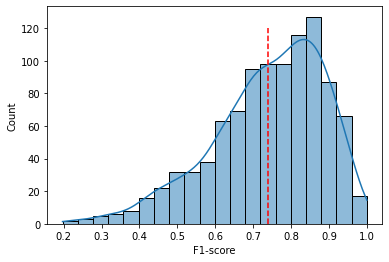

In [29]:
f1_scores = np.array(pd.read_csv('classification_report.csv')['F1 score'])
ax = sns.histplot(data=f1_scores, bins=20, kde=True)
mean = np.mean(f1_scores)
plt.plot([mean, mean], [0, 120], 'r--')
ax.set(xlabel='F1-score', ylabel='Count')
plt.show()


It is interesting to see which class has the minimal F1-score:

In [30]:
min_f1_scores = np.argsort(f1_scores)[:10]
print(min_f1_scores)
print('The 10 classes with the lowest F1-scores are (in increasing order):')
for i in range(len(min_f1_scores)):
    print('"' + categories[str(min_f1_scores[i])] + '"')

[744 681 885 638 782 600 664 282 620 836]
The 10 classes with the lowest F1-scores are (in increasing order):
"projectile, missile"
"notebook, notebook computer"
"velvet"
"maillot"
"screen, CRT screen"
"hook, claw"
"monitor"
"tiger cat"
"laptop, laptop computer"
"sunglass"


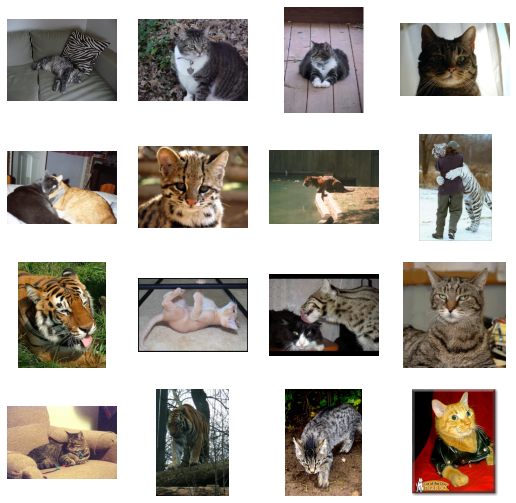

In [34]:
plot_images(min_f1_scores[7])  # corresponds to the class 'tiger cat'

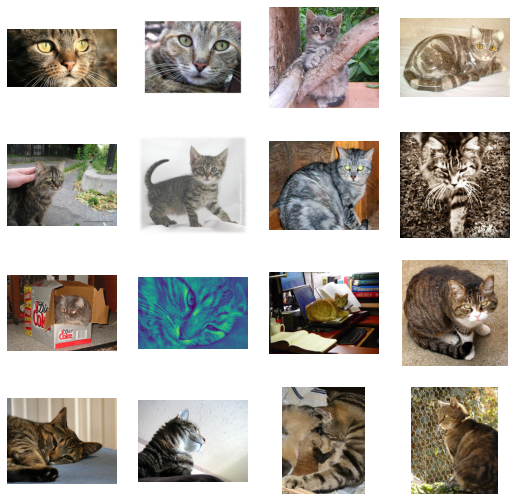

F1-score for the class 'Persian cat' 0.5981308


In [35]:
plot_images(281) # associated with the category 'Persian cat'
print("F1-score for the class 'Persian cat'", f1_scores[281])

We observe that some classes look very similar to others (that's the case for "tiger cats" and "persian cats"). That can explain that the corresponding F1-scores are particulary low. 

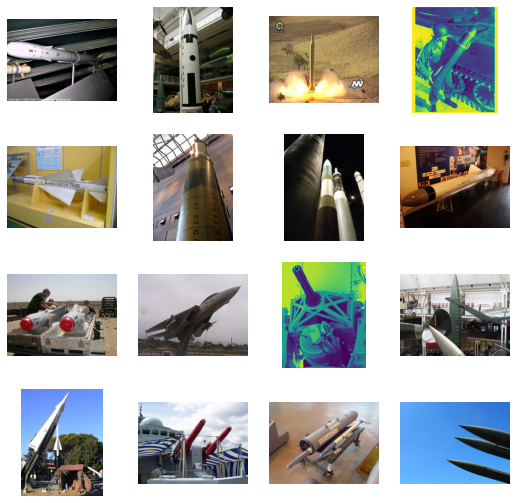

In [36]:
plot_images(min_f1_scores[0])  # corresponds to the class 'projectile, missile'

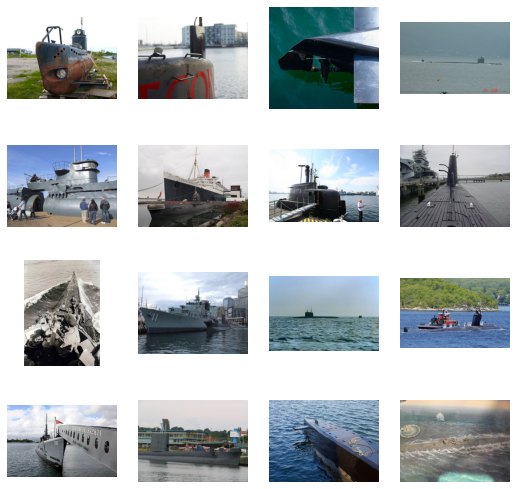

In [37]:
plot_images(833)  # corresponds to the class 'missile'

Again, the classes 'projectile missile' is very similar to other classes (like 'submarines' or 'missiles'). That maybe explains that the F1-score and the precision are relatively low. The following cell outputs the labels of the False Negatives (ie) the wrong predictions of the model when a 'projectile, missile' image is given in input.

In [38]:
detected_prison = list(set([np.argmax(logits[i]).item() for i in range(len(labels)) if labels[i] == 744]))
print('Here are the false negatives (classes that the model has detected instead of "Projectile, missile"):')
for i in detected_prison:
    if i!= 744:
        print('"' + categories[str(i)] + '"')

Here are the false negatives (classes that the model has detected instead of "Projectile, missile"):
"submarine, pigboat, sub, U-boat"
"mosque"
"trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi"
"potter's wheel"
"guillotine"
"solar dish, solar collector, solar furnace"
"ladle"
"punching bag, punch bag, punching ball, punchball"
"space shuttle"
"tank, army tank, armored combat vehicle, armoured combat vehicle"
"missile"
"vault"
"beacon, lighthouse, beacon light, pharos"
"rifle"
"parallel bars, bars"
"warplane, military plane"


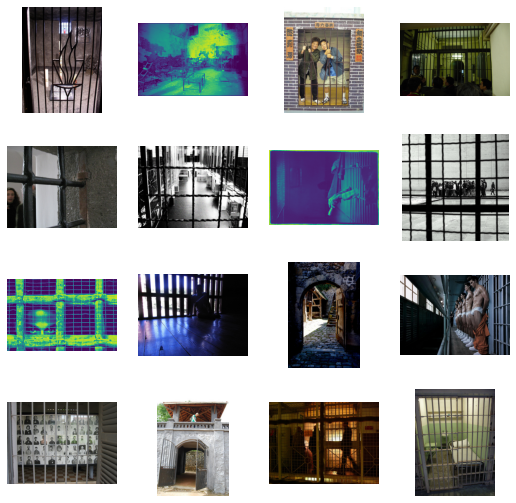

0.631579


In [39]:
plot_images(743)
print(f1_scores[743])

Some classes have no clear pattern or charasteristics to detect. For example, the only specificity of prisons is cells' bars, that are either hardly distinguable on the given images, or vary a lot from an image to another. That can explain that the model struggles to detect such features.

Other problems of the ImageNet dataset are well described in this paper: https://arxiv.org/pdf/2006.07159.pdf (particularly the fact that for some classes, many elements are present on the images and constitute sources of errors for the model)

Same for maximal F1-scores:

In [41]:
max_f1_scores = np.argsort(f1_scores)[-10:]
print(max_f1_scores)
print('The 10 classes with the highest F1-scores are (in decreasing order):')
for i in range(len(max_f1_scores)):
    print('"' + categories[str(max_f1_scores[i])] + '"')

[339  90 255 604 685 984 135   9  24 986]
The 10 classes with the highest F1-scores are (in decreasing order):
"sorrel"
"lorikeet"
"Leonberg"
"hourglass"
"odometer, hodometer, mileometer, milometer"
"rapeseed"
"limpkin, Aramus pictus"
"ostrich, Struthio camelus"
"great grey owl, great gray owl, Strix nebulosa"
"yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum"


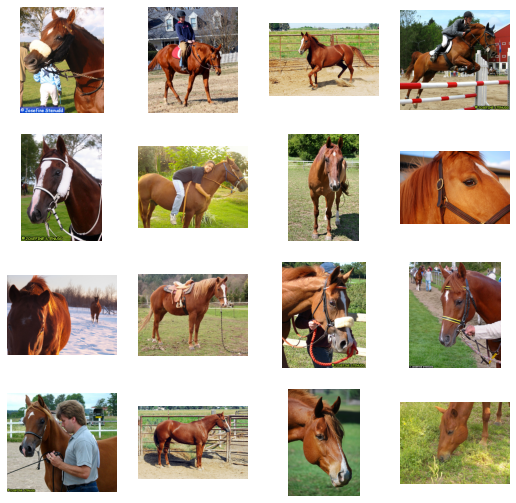

In [117]:
plot_images(max_f1_scores[0])